> ### 파일 경로만 수정해주세요

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate, Flatten, Reshape
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

traffic_5min = pd.read_csv("../seq=4, shift=10/accident_10_min_before.csv", encoding='cp949', index_col=0)
traffic_10min = pd.read_csv("../seq=4, shift=10/accident_20_min_before.csv", encoding='cp949', index_col=0)
traffic_15min = pd.read_csv("../seq=4, shift=10/accident_30_min_before.csv", encoding='cp949', index_col=0)
traffic_20min = pd.read_csv("../seq=4, shift=10/accident_40_min_before.csv", encoding='cp949', index_col=0)

non_traffic_5min = pd.read_csv("../seq=4, shift=10/non_accident_10_min_before.csv", encoding='cp949', index_col=0)
non_traffic_10min = pd.read_csv("../seq=4, shift=10/non_accident_20_min_before.csv", encoding='cp949', index_col=0)
non_traffic_15min = pd.read_csv("../seq=4, shift=10/non_accident_30_min_before.csv", encoding='cp949', index_col=0)
non_traffic_20min = pd.read_csv("../seq=4, shift=10/non_accident_40_min_before.csv", encoding='cp949', index_col=0)

> ### data.sample(개수) 로 원하는 샘플링 비율 맞출 수 있습니다.
> #### 1 : 1 = len(data) , 1 : 2 = len(data) * 2...

In [2]:
non_traffic_5min = non_traffic_5min.sample(len(traffic_5min))
non_traffic_10min = non_traffic_10min.sample(len(traffic_5min))
non_traffic_15min = non_traffic_15min.sample(len(traffic_5min))
non_traffic_20min = non_traffic_20min.sample(len(traffic_5min))

In [3]:
static_traffic = traffic_5min[['lanes', 'speed_limit', 'length', 'bump', 'camera']].to_numpy()
static_non_traffic = non_traffic_5min[['lanes', 'speed_limit', 'length', 'bump', 'camera']].to_numpy()

In [4]:
dynamic_traffic_5min = traffic_5min.drop(['datetime', 'link', 'lanes','speed_limit','length', 'bump', 'camera' ,'label'], axis=1).to_numpy()
dynamic_traffic_10min = traffic_10min.drop(['datetime', 'link', 'lanes','speed_limit','length', 'bump', 'camera' ,'label'], axis=1).to_numpy()
dynamic_traffic_15min = traffic_15min.drop(['datetime', 'link', 'lanes','speed_limit','length', 'bump', 'camera' ,'label'], axis=1).to_numpy()
dynamic_traffic_20min = traffic_20min.drop(['datetime', 'link', 'lanes','speed_limit','length', 'bump', 'camera' ,'label'], axis=1).to_numpy()

dynamic_non_traffic_5min = non_traffic_5min.drop(['datetime', 'link', 'lanes','speed_limit','length', 'bump', 'camera' ,'label'], axis=1).to_numpy()
dynamic_non_traffic_10min = non_traffic_10min.drop(['datetime', 'link', 'lanes','speed_limit','length', 'bump', 'camera' ,'label'], axis=1).to_numpy()
dynamic_non_traffic_15min = non_traffic_15min.drop(['datetime', 'link', 'lanes','speed_limit','length', 'bump', 'camera' ,'label'], axis=1).to_numpy()
dynamic_non_traffic_20min = non_traffic_20min.drop(['datetime', 'link', 'lanes','speed_limit','length', 'bump', 'camera' ,'label'], axis=1).to_numpy()


In [5]:
traffic_label = traffic_5min['label'].to_numpy()
non_traffic_label = non_traffic_5min['label'].to_numpy()

In [6]:
X, Y = [], []
for accident in range(len(dynamic_traffic_5min)):
    X.append([dynamic_traffic_20min[accident], dynamic_traffic_15min[accident], dynamic_traffic_10min[accident], dynamic_traffic_5min[accident]])
    Y.append(traffic_label[accident])

X = np.array(X)
Y = np.array(Y)

posx_train, posx_test, posy_train, posy_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
posx_val, posx_test, posy_val, posy_test = train_test_split(posx_test, posy_test, test_size=0.5, random_state=42, shuffle=True)

psttx_train, psttx_test, pstty_train, pstty_test = train_test_split(static_traffic, Y, test_size=0.2, random_state=42, shuffle=True)
psttx_val, psttx_test, pstty_val, pstty_test = train_test_split(psttx_test, pstty_test, test_size=0.5, random_state=42, shuffle=True)


In [7]:
X, Y = [], []
for non_accident in range(len(dynamic_non_traffic_5min)):
    X.append([dynamic_non_traffic_20min[non_accident], dynamic_non_traffic_15min[non_accident], dynamic_non_traffic_10min[non_accident], dynamic_non_traffic_5min[non_accident]])
    Y.append(non_traffic_label[non_accident])

X = np.array(X)
Y = np.array(Y)

negx_train, negx_test, negy_train, negy_test = train_test_split(X, Y, test_size=0.2, random_state=44, shuffle=True)
negx_val, negx_test, negy_val, negy_test = train_test_split(negx_test, negy_test, test_size=0.5, random_state=44, shuffle=True)

nsttx_train, nsttx_test, nstty_train, nstty_test = train_test_split(static_non_traffic, Y, test_size=0.2, random_state=44, shuffle=True)
nsttx_val, nsttx_test, nstty_val, nstty_test = train_test_split(nsttx_test, nstty_test, test_size=0.5, random_state=44, shuffle=True)

> ### posx, negx는 dynamic feature를 positive, negative로 나누었습니다.
> ### psttx, nsttx는 static feature를 positive, negative로 나누었습니다.

In [8]:
X_train = np.concatenate((posx_train, negx_train), axis=0)
X_val = np.concatenate((posx_val, negx_val), axis=0)
X_test = np.concatenate((posx_test, negx_test), axis=0)

sX_train = np.concatenate((psttx_train, nsttx_train), axis=0)
sX_val = np.concatenate((psttx_val, nsttx_val), axis=0)
sX_test = np.concatenate((psttx_test, nsttx_test), axis=0)

Y_train = np.concatenate((posy_train, negy_train), axis=0)
Y_val = np.concatenate((posy_val, negy_val), axis=0)
Y_test = np.concatenate((posy_test, negy_test), axis=0)

> ### shuffled_indices를 통해 Train, Val, Test에 대해서 각각 셔플링을 진행하되, 셔플링된 인덱스는 Task별 Dynamic, Static, Label에 공유되도록 하였습니다.

In [9]:
shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffled_indices]
sX_train = sX_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

shuffled_indices = np.random.permutation(len(X_val))
X_val = X_val[shuffled_indices]
sX_val = sX_val[shuffled_indices]
Y_val = Y_val[shuffled_indices]

shuffled_indices = np.random.permutation(len(X_test))
X_test = X_test[shuffled_indices]
sX_test = sX_test[shuffled_indices]
Y_test = Y_test[shuffled_indices]

> ### Label을 활용하여 밑에 있는 코드에서 샘플링 비율이 맞는지 확인할 수 있습니다.

> #### Train 비율

In [10]:
unique, counts = np.unique(Y_train, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))
uniq_cnt_dict

{0: 19711, 1: 19711}

> #### Validation 비율

In [11]:
unique, counts = np.unique(Y_val, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))
uniq_cnt_dict

{0: 2464, 1: 2464}

> #### Test 비율

In [12]:
unique, counts = np.unique(Y_test, return_counts = True)
uniq_cnt_dict = dict(zip(unique, counts))
uniq_cnt_dict

{0: 2464, 1: 2464}

In [13]:
def LS_DS(ls, ls_ds, ds):
    input_dy = Input(shape=(4, 11))
    input_st = Input(shape=(5,))

    # Dynamic Feature
    lstm_1 = LSTM(ls, return_sequences=True)(input_dy)
    lstm_2 = LSTM(ls + 32, return_sequences=False)(lstm_1)
    dense_1 = Dense(ls_ds, activation='relu')(lstm_2)

    # Static Feature
    dense_2 = Dense(ds, activation='relu')(input_st)
    dense_3 = Dense(ds, activation='relu')(dense_2)
    
    # Concatenate
    concat = concatenate([dense_1, dense_3], axis=1)
    dense_4 = Dense(20, activation='relu')(concat)

    # Output
    flat = Flatten()(dense_4)
    out = Dense(1, activation='sigmoid')(flat)

    m = Model ([input_dy, input_st], out)
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.BinaryAccuracy(threshold=0.5)])
   
    return m

In [ ]:
m = LS_DS(32, 40, 50)

hist = m.fit([X_train, sX_train], Y_train, validation_data=([X_val, sX_val], Y_val), epochs=50, batch_size=64, verbose=1)

In [ ]:
loss, acc, auc, precision, recall, binary_accuracy = m.evaluate([X_test, sX_test], Y_test, batch_size=32)

print("m parameter", m.count_params())
print('loss : ', loss)
print('acc : ', acc)
print('auc : ', auc)
print('precision : ', precision)
print('recall : ', recall)
print('binary_accuracy : ', binary_accuracy)
#print f1-score with calculate recall precision

f1_score = (2 * precision * recall) / (precision + recall)
print('f1_score : ', f1_score)

157/157 [==============================] - 0s 1ms/step - loss: 0.6519 - accuracy: 0.6140 - auc: 0.6578 - precision_7: 0.5965 - recall_7: 0.6850 - binary_accuracy: 0.6140
m parameter 35635
loss :  0.6518973708152771
acc :  0.614003598690033
auc :  0.6578006744384766
precision :  0.5964973568916321
recall :  0.6850361824035645
binary_accuracy :  0.614003598690033
f1_score :  0.6377082762946488


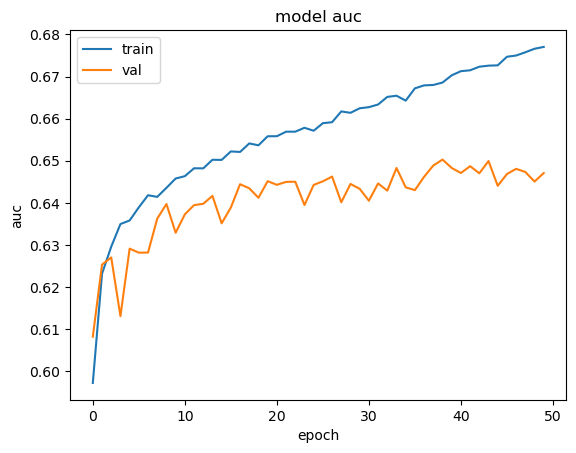

In [ ]:
from matplotlib import pyplot as plt

plt.plot(hist.history['auc'])
plt.plot(hist.history['val_auc'])
plt.title('model auc')

plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()